# Clustering networks

In [120]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log
_log.setLevel('ERROR')

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import Counter
from hdbscan import HDBSCAN
from matplotlib.cm import get_cmap
from sklearn.manifold import spectral_embedding
from umap import UMAP

%matplotlib inline

seed = 42
random_state = np.random.RandomState(seed)

Defining the network:

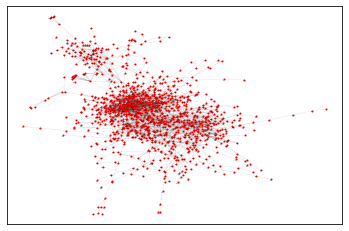

In [121]:
# G = nx.erdos_renyi_graph(1000, .003, seed=seed)
G = nx.read_edgelist("air_traffic.edgelist")
# G = nx.read_edgelist("academic_collaboration.edgelist")

pos = nx.fruchterman_reingold_layout(G, seed=seed)

nx.draw_networkx_nodes(G, pos=pos, node_size=1, node_color="red")
nx.draw_networkx_edges(G, pos=pos, width=.05)
nx.draw_networkx_labels(G, pos=pos, font_size=1)
plt.savefig("graph.pdf")
plt.show()

Reducing dimensions with Spectral Embedding and UMAP and clustering with HDBSCAN:

clusters: 14
noise level: 0.192


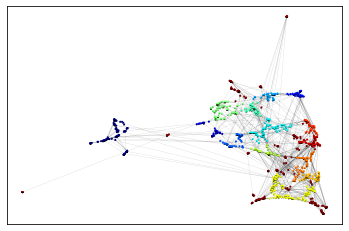

In [122]:
adj_matrix = nx.to_numpy_array(G)
node_list = list(G.nodes()) 

embedding = spectral_embedding(adj_matrix, n_components=50, drop_first=False, random_state=random_state)
embedding = UMAP(n_components=2, n_neighbors=30, min_dist=0.0, random_state=random_state).fit_transform(embedding)
clusters = HDBSCAN(min_samples=1, min_cluster_size=40).fit_predict(embedding)

print(f"clusters: {np.amax(clusters) + 1}")
print(f"noise level: {np.round(Counter(clusters)[-1] / len(clusters), 3)}")

cmap = get_cmap('jet')(np.linspace(0, 1.0, np.amax(clusters) + 2))
pos = {node_list[i]: embedding[i] for i in range(len(node_list))}

nx.draw_networkx_nodes(G, pos=pos, node_size=1, node_color=[cmap[clusters[i]] for i in range(len(clusters))])
nx.draw_networkx_edges(G, pos=pos, width=.05)
nx.draw_networkx_labels(G, pos=pos, font_size=1)
plt.savefig("graph_clustered.pdf")
plt.show()

Removing nodes labeled as noise by HDBSCAN:

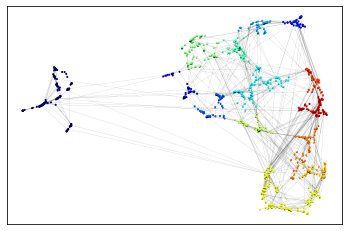

In [123]:
G.remove_nodes_from([node_list[i] for i in range(len(node_list)) if clusters[i] == -1])
node_list = list(G.nodes())
clusters = [clusters[i] for i in range(len(clusters)) if clusters[i] != -1]

nx.draw_networkx_nodes(G, pos=pos, node_size=1, node_color=[cmap[clusters[i]] for i in range(len(clusters))])
nx.draw_networkx_edges(G, pos=pos, width=.05)
nx.draw_networkx_labels(G, pos=pos, font_size=1)
plt.savefig("graph_clustered_without_noise.pdf")